*Basic CNV simulation*  
Grace Avecilla  
started 17 December 2019  

This is a very basic simulation of CNV evolution where there is one class of CNVs with some mutation rate and some fitness effect and one class of other variants (which I will be calling SNVs) with some mutation rate and some fitness effect. Both classes of mutations are only going to generate beneficial mutations, because the population sizes are very large, so the effect of deleterious mutations should be minimal. 

I am also going to have mutations only go in one direction (from no mutations to mutant), and only allow one type of mutation at a time (so there are no mutants with both CNV and SNV).

Simulations are performed, then ABC to compare to proportion of population with a CNV at 25 timepoint in simulations to experimental data from Lauer et al. 2018.

In [1]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import sympy
import seaborn as sns
import pandas as pd
import numba
from scipy.stats import entropy

red, blue, green = sns.color_palette('Set1', 3)

In [2]:
N=3e8
s_cnv=np.log10(0.001)
#s_snv=0.002  # Venkataram et al. 2016
s_snv=0.001
m_cnv=np.log10(1e-7)
#m_snv=1.67e-10 #SNV mutation rate: 1.67 x 10^-10 per base per generation (Zhu et al. 2014)
m_snv=1e-7


N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV

In [3]:
def simulation(N, s_cnv, s_snv, m_cnv, m_snv, repetitions=1000):
    assert N > 0
    N = np.uint64(N)
    s_cnv = np.power(10, s_cnv) #modeled the log10 of the priors, transform back
    m_cnv = np.power(10, m_cnv) #modeled the log10 of the priors, transform back
      
    w = np.array([1, 1 + s_cnv, 1 + s_snv])
    S = np.diag(w)
    
    # make transition rate array
    M = np.array([[1 - m_cnv - m_snv, 0, 0],
                 [m_cnv, 1, 0],
                 [m_snv, 0, 1]])
    
    # mutation and selection
    E = M @ S

    # rows are genotypes, cols are repetitions
    n = np.zeros((3, repetitions))
    n[0,:] = N    
    
    # follow proportion of the population with CNV
    # here rows with be generation, columns will be repetition
    p_cnv = []
    
    # run simulation to generation 267
    for t in range(0,268):    
        p = n/N  # counts to frequencies
        p_cnv.append(p[1,:])  # frequency of CNVs
        p = E @ p  # natural selection + mutation        
        p /= p.sum(axis=0)  # rescale proportions
        for j in range(0,repetitions):
            # random genetic drift
            n[:,j] = np.random.multinomial(N, p[:,j])
        
    return p_cnv

Since this is a first, very preliminary simulation, I am making the fitness effect for CNVs and SNVs the same, so we will be examining solely the effect of having two classes of mutations with different rates.

SNV mutation rate: 1.67 x 10^-10 per base per generation (Zhu et al. 2014)  

CNV mutation rate: 3.4 x 10-6 gene duplications per gene per generation (Lynch et al. 2008)  
Fitness effect: mean s = .85 (Frenkel et al. 2014, Rice et al. 2015) 

Population size in Lauer et al. 2018: 3e8

In [4]:

freq_cnv = simulation(N, s_cnv, s_snv, m_cnv, m_snv, repetitions=1000)

In [5]:
freq_cnv = np.array(freq_cnv).squeeze()
df = pd.DataFrame(data=freq_cnv)
df['Generation'] = df.index
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Generation
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
1,1.100000e-07,1.100000e-07,9.000000e-08,9.000000e-08,1.100000e-07,9.333333e-08,1.533333e-07,1.233333e-07,8.333333e-08,9.000000e-08,...,1.000000e-07,9.333333e-08,6.000000e-08,1.166667e-07,1.200000e-07,8.000000e-08,1.100000e-07,8.000000e-08,1.066667e-07,1
2,2.266667e-07,2.333333e-07,1.800000e-07,1.933333e-07,1.566667e-07,2.333333e-07,2.366667e-07,2.400000e-07,1.700000e-07,1.533333e-07,...,1.833333e-07,1.833333e-07,1.400000e-07,2.166667e-07,2.100000e-07,1.566667e-07,2.166667e-07,1.900000e-07,2.066667e-07,2
3,3.100000e-07,3.333333e-07,2.566667e-07,3.000000e-07,1.833333e-07,3.400000e-07,2.933333e-07,2.800000e-07,2.466667e-07,1.833333e-07,...,2.233333e-07,3.000000e-07,2.600000e-07,3.166667e-07,2.533333e-07,3.033333e-07,2.733333e-07,3.033333e-07,2.933333e-07,3
4,4.166667e-07,4.666667e-07,3.566667e-07,3.666667e-07,3.000000e-07,3.700000e-07,3.600000e-07,4.333333e-07,3.633333e-07,3.466667e-07,...,2.900000e-07,3.733333e-07,3.766667e-07,4.200000e-07,3.233333e-07,4.133333e-07,3.633333e-07,3.766667e-07,4.000000e-07,4


In [6]:
df = pd.melt(df, id_vars='Generation', var_name='Replicate', value_name='Freq_CNV')
#df.head()

In [7]:
mean_df = df.groupby('Generation')['Freq_CNV'].mean().reset_index()
#mean_df.head()

In [8]:
grp = df.groupby('Replicate')
filtered = grp.filter(lambda x: random.random() < 0.05)

In [9]:
pivoted = filtered.pivot('Generation', 'Replicate', 'Freq_CNV')
#pivoted.head()
#pivoted.tail()

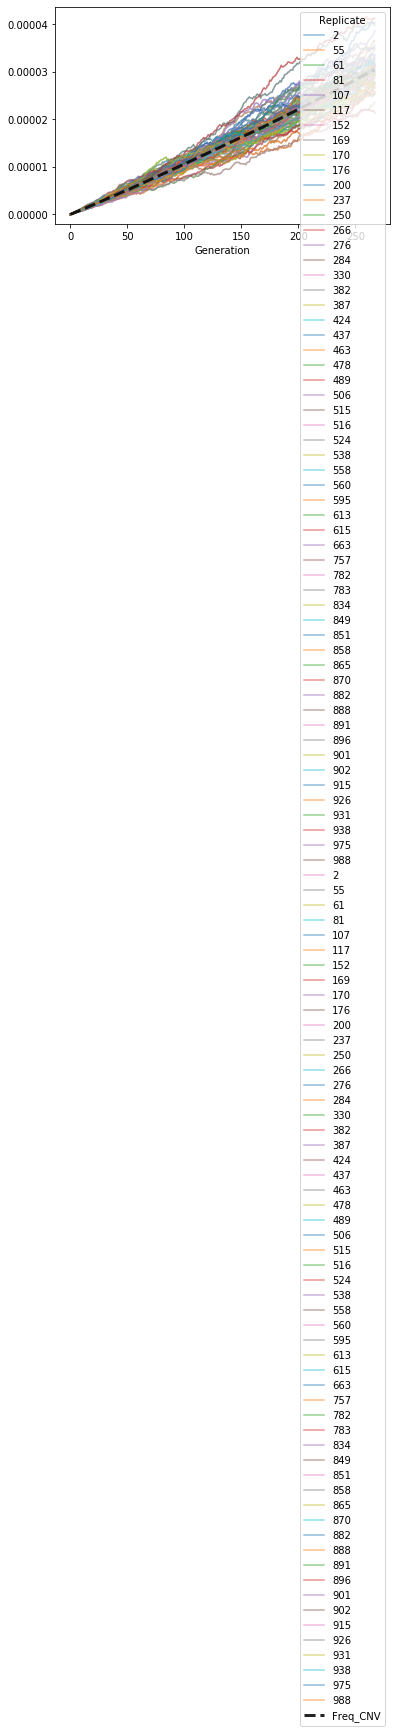

In [10]:
ax = pivoted.plot(alpha=0.5)
pivoted.plot(alpha=0.5, ax=ax)
mean_df.plot('Generation', 'Freq_CNV', color='k', alpha=0.85, ls='--', lw=3, ax=ax)

For ABC, I am worried about the about of data we have (9 populations) vs the amount of simulations we do for each set of parameters. I don't have a great intuition for how this will affect things, nor do I know what a great distance function is, so I will do the following:
    1. Try several different distance functions
    2. Use a subsample from the simulations as my "real" data

As a start, for the distance function I will use Kullback-Leibler (KL) divergence at each 25 timepoints that were measured in Lauer et al. 2018. Then I will sum the entropy values for the entire set of timepoints. 

1. Subset out from simulation the 25 timepoints
2. Randomly subset out from original simulation 9 replicates to use as "real data"
3. Simulate data over some parameters & subset 25 timepoints
4. For each time point, summarize the real data using a histogram.
5. For each time point, summarize the simulations using a histogram with the same bins
6. Sum the entropy over all time points



In [11]:
exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
#get "real data" by randomly subseting 9 cols from original simulation
real_data = freq_cnv[:,np.random.choice(freq_cnv.shape[1], 9, replace=False)]
real_data.shape
#real_data = np.array(pd.read_csv('PopPropForABC.csv')) #real real data 

(268, 9)

In [12]:
# let's just change CNV mutation rate and fitness effect in simulations for now
reps = 250
rates = np.random.uniform(np.log10(1e-12), np.log10(1e-4), size=reps)
effects = np.random.uniform(np.log10(1e-3), np.log10(0.3), size=reps)
sim_data = np.empty([250,268,500])
#there is probably a faster way to do this, I haven't figured it out yet
for i in range(0,reps):
    sim_data[i] = simulation(N, effects[i], s_snv, rates[i], m_snv, repetitions=500)


In [13]:
# get only the generations from exp data
#sim_data = sim_data[:,exp_gen,:]
sim_data.shape

(250, 268, 500)

In [14]:
#g = exp_gen[1]
#g
#counts, bins = np.histogram(real_data[g])
#counts
#bins
#counts_sim = np.array([
#    np.histogram(sim_data[i,g,:], bins=bins)[0]
#    for i in range(reps)
#])
#counts_sim

In [15]:
#remove 0s
#counts_sim = counts_sim.astype(float)
#counts_sim[counts_sim==0] = 1e-6

#counts = counts.astype(float)
#counts[counts==0] = 1e-6

In [16]:
#KL += np.array([entropy(pk=counts, qk=counts_sim[i]) for i in range(reps)])

In [17]:
KL = np.empty(250)
x=0
for g in exp_gen:
    counts, bins = np.histogram(real_data[g])
    counts_sim = np.array([
        np.histogram(sim_data[i,g,:], bins=bins)[0]
        for i in range(reps)
    ])
    counts_sim = counts_sim.astype(float)
    counts_sim[counts_sim==0] = 1e-6
    
    counts = counts.astype(float)
    counts[counts==0] = 1e-6
    KL += np.array([entropy(pk=counts, qk=counts_sim[i]) for i in range(reps)])
    #x+=1


In [18]:
#average KL over all generations examined?
KL = KL/25

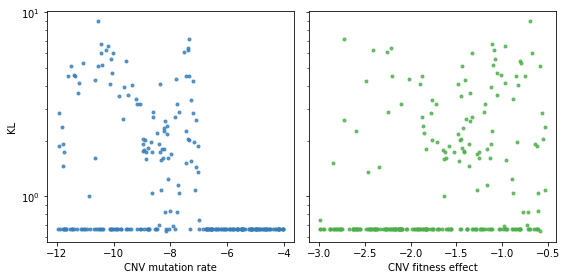

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plot_kws = dict(marker='.', ls='', alpha=0.8)
argmin_kws = dict(marker='.', ls='', alpha=0.1, color=red, markersize=5)
vline_kws = dict(color=red)
                  
ax = axes[0]
ax.plot(rates, KL, color=blue, **plot_kws)
#ax.axvline(m_cnv, **vline_kws)
ax.set(xlabel='CNV mutation rate', yscale='log', ylabel='KL')

ax = axes[1]
ax.plot(effects, KL, color=green, **plot_kws)
#ax.axvline(s_cnv, **vline_kws)
ax.set(xlabel='CNV fitness effect')

fig.tight_layout()

In [31]:
#rejection sampling
# I just chose ϵ that gives me enough accepted to test the code
ϵ = 0.68

idx_accepted = KL < ϵ
print("Accepted {} ({:.2%}) of {} generated samples".format(
    idx_accepted.sum(), idx_accepted.mean(), idx_accepted.size))
rates_accepted = rates[idx_accepted]
effects_accepted = effects[idx_accepted]

Accepted 152 (60.80%) of 250 generated samples


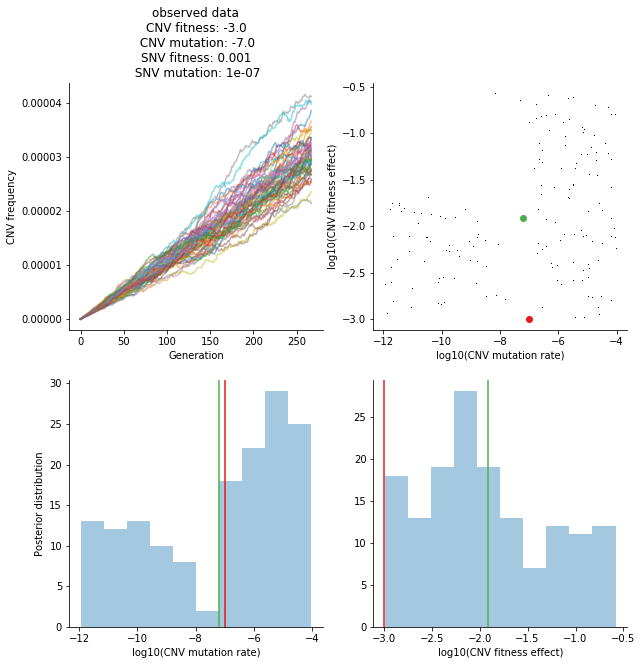

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# observed
axes[0,0].plot(pivoted,alpha=0.5)
axes[0,0].set(ylabel='CNV frequency', xlabel='Generation')
#color='k', alpha=0.85, ls='--', lw=3
axes[0,0].set_title('observed data\nCNV fitness: ' + str(s_cnv) + '\n CNV mutation: ' + str(m_cnv)+'\nSNV fitness: ' + str(s_snv) + '\n SNV mutation: ' + str(m_snv))

#joint
axes[0,1].plot(rates_accepted, effects_accepted, ',k')
axes[0,1].plot(m_cnv, s_cnv, color=red, marker='o')
axes[0,1].plot(rates_accepted.mean(), effects_accepted.mean(), color=green, marker='o')
axes[0,1].set(xlabel='log10(CNV mutation rate)',ylabel='log10(CNV fitness effect)')

# marginal
sns.distplot(rates_accepted, bins=10, kde=False, ax=axes[1,0]) #fit=scipy.stats.norm
axes[1,0].axvline(m_cnv, color=red)
axes[1,0].axvline(rates_accepted.mean(), color=green)
axes[1,0].set(xlabel='log10(CNV mutation rate)', ylabel='Posterior distribution')

sns.distplot(effects_accepted, bins=10, kde=False, ax=axes[1,1])#fit=scipy.stats.norm
axes[1,1].axvline(s_cnv, color=red)
axes[1,1].axvline(effects_accepted.mean(), color=green)
axes[1,1].set(xlabel='log10(CNV fitness effect)')


#fig.tight_layout()
plt.title('')
sns.despine()
outfile = 'abc_wswm'
plt.savefig(outfile + '.pdf')  

In [22]:
def format(value):
    return "%.12f" % value

f= open("est_real_params_abc.csv","a+")
f.write(','.join(str(format(j)) for j in (s_cnv,effects_accepted.mean(),m_cnv,rates_accepted.mean(),s_snv,m_snv)) + '\n')
f.close() 

In [22]:
rates_accepted

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])